 # Evaluate the model performance


- semantic-level similarity (METEOR and BERTScore)
- word and sequence level overlap (BLEU and ROUGE scores)
- human evaluation


Explanations for the evaluation scores

- Average BERTScore

BERTScore is a metric used to measure the semantic similarity between generated text and reference text. It utilizes a pre-trained BERT model to encode sentences and computes similarity scores between them.

- Average METEOR Score

The METEOR score is another metric for assessing machine translation quality, considering both word-level alignment and sentence-level semantic similarity.

- Average BLEU Score

BLEU is a commonly used metric for machine translation evaluation. It evaluates translation quality by calculating the exact matching of n-grams in the generated text with those in the reference text, though it may overlook semantic similarity at the sentence level.

- Average Rouge Score

ROUGE scores are used to evaluate the overlap between generated text and reference text, including both word-level and sentence-level overlap. Here, the average scores for three ROUGE metrics are provided:

rouge-1: Indicates the overlap between individual words generated by the model and those in the reference text.

rouge-2: Reflects the overlap between phrases composed of two words generated by the model and those in the reference text.

rouge-l: Represents the length of the longest common subsequence between the text generated by the model and the reference text, i.e., the overlap at the sentence level.

In summary, METEOR and BERTScore focus on evaluating semantic-level similarity, whereas BLEU and ROUGE primarily assess overlap at the word and sequence levels.

### Evaluate

For evaluation, connected to L4 GPU in Colab

In [1]:
!pip install rouge
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 688.3 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')   # connect to gdrive

# Change working directory to be current folder
import os
os.chdir('/content/gdrive/My Drive/Practice/4/ml-arxiv-papers')



Mounted at /content/gdrive


1) Evaluate the finetuned llama2-7b-chat inference results

In [ ]:
# Load and check the results JSON file

import json

with open("./llama2-7b-chat/test_dataset_inference_results_0_best.json", "r") as f:
    test_dataset_results = json.load(f)
print("# results samples:", len(test_dataset_results))

# Check some samples
test_dataset_results[-2:]


# results samples: 1000


[{'id': 114587,
  'question': 'What is the impact of sub-task decomposition on learning in sequence to sequence tasks?',
  'ground_truth': 'Sub-task decomposition enables the learnability of composite problems by introducing intermediate supervision. It shows that learning in the presence of intermediate supervision is facilitated, making previously unlearnable problems achievable through training on a modified input that concatenates sub-task labels with the original input. This approach ensures that tasks, which are otherwise unlearnable, can be broken down into simpler sub-tasks, leading to successful learning outcomes in sequence-to-sequence models.',
  'answer': "Sub-task decomposition has been shown to be effective in enabling learning in sequence to sequence tasks. By decomposing complex problems into simpler sub-tasks and incorporating intermediate supervision, unlearnable problems can become learnable. This approach involves feeding a sequence-to-sequence model with an augment

In [ ]:
# Evaluating results, tekes around 15 mins using L4 GPU

# Optimized code
# semantic similarity (METEOR and BERTScore)
# word and phrase level overlap (BLEU and ROUGE scores)

import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from bert_score import score

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')

def calculate_scores(results):
    total_bert_score = 0
    total_meteor_score = 0
    total_bleu_score = 0
    total_rouge_score = {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}
    num_results = len(results)

    for result in results:
        answer = result.get('answer')
        ground_truth = result.get('ground_truth')

        if not answer or not ground_truth:
            continue  # Skip empty answers or ground truths

        # Tokenize hypothesis and reference
        hypothesis_tokens = word_tokenize(answer)
        reference_tokens = word_tokenize(ground_truth)

        # BERTScore
        _, _, F1 = score([answer], [ground_truth], lang='en', verbose=False)  # P, R, F1 = score(cands, refs, lang="en", verbose=False)
        total_bert_score += F1.item()

        # METEOR
        meteor = meteor_score([reference_tokens], hypothesis_tokens)
        total_meteor_score += meteor

        # BLEU
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=None)
        total_bleu_score += bleu_score

        # ROUGE
        rouge = Rouge()
        rouge_scores = rouge.get_scores(answer, ground_truth)[0]
        for metric, scores in rouge_scores.items():
            total_rouge_score[metric] += scores['f']

    average_bert_score = total_bert_score / num_results
    average_meteor_score = total_meteor_score / num_results
    average_bleu_score = total_bleu_score / num_results
    average_rouge_score = {metric: score / num_results for metric, score in total_rouge_score.items()}

    return average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score


def load_results(file_path):
    try:
        with open(file_path, "r") as f:
            results = json.load(f)
        return results
    except FileNotFoundError:
        print("File not found:", file_path)
    except json.JSONDecodeError:
        print("Invalid JSON format in file:", file_path)
    return []


if __name__ == "__main__":
    # Define file path
    file_path = "./llama2-7b-chat/test_dataset_inference_results_0_best.json"  # path to the results file

    # Load results
    results = load_results(file_path)

    # Calculate scores
    if results:
        average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score = calculate_scores(results)

        # Print average scores
        print("Average BERTScore(F1):", average_bert_score)
        print("Average METEOR score:", average_meteor_score)
        print("Average BLEU score:", average_bleu_score)
        print("Average Rouge score:", average_rouge_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average BERTScore(F1): 0.9171436856389046
Average METEOR score: 0.5474461102655611
Average BLEU score: 0.22939051090323534
Average Rouge score: {'rouge-1': 0.5326981310578925, 'rouge-2': 0.3065083438932236, 'rouge-l': 0.5008402663761499}


2) Evaluate the base llama2-7b-chat model inference results

In [ ]:
# Load and check the results JSON file

import json

with open("./llama2-7b-chat/test_dataset_inference_results_base.json", "r") as f:
    test_dataset_results = json.load(f)
print("# results samples:", len(test_dataset_results))

# Check some samples
test_dataset_results[-2:]


# results samples: 1000


[{'id': 114587,
  'question': 'What is the impact of sub-task decomposition on learning in sequence to sequence tasks?',
  'ground_truth': 'Sub-task decomposition enables the learnability of composite problems by introducing intermediate supervision. It shows that learning in the presence of intermediate supervision is facilitated, making previously unlearnable problems achievable through training on a modified input that concatenates sub-task labels with the original input. This approach ensures that tasks, which are otherwise unlearnable, can be broken down into simpler sub-tasks, leading to successful learning outcomes in sequence-to-sequence models.',
  'answer': '\nSub-task decomposition has a significant impact on learning in sequence-to-sequence tasks, as it enables the use of intermediate supervision to make previously unlearnable problems learnable. By breaking down complex tasks into simpler sub-tasks, the model can learn each sub-task independently and then combine them to s

In [ ]:
# Evaluating results, tekes around 15 mins using L4 GPU

# Optimized code
# semantic similarity (METEOR and BERTScore)
# word and phrase level overlap (BLEU and ROUGE scores)

import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from bert_score import score

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')

def calculate_scores(results):
    total_bert_score = 0
    total_meteor_score = 0
    total_bleu_score = 0
    total_rouge_score = {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}
    num_results = len(results)

    for result in results:
        answer = result.get('answer')
        ground_truth = result.get('ground_truth')

        if not answer or not ground_truth:
            continue  # Skip empty answers or ground truths

        # Tokenize hypothesis and reference
        hypothesis_tokens = word_tokenize(answer)
        reference_tokens = word_tokenize(ground_truth)

        # BERTScore
        _, _, F1 = score([answer], [ground_truth], lang='en', verbose=False)  # P, R, F1 = score(cands, refs, lang="en", verbose=False)
        total_bert_score += F1.item()

        # METEOR
        meteor = meteor_score([reference_tokens], hypothesis_tokens)
        total_meteor_score += meteor

        # BLEU
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=None)
        total_bleu_score += bleu_score

        # ROUGE
        rouge = Rouge()
        rouge_scores = rouge.get_scores(answer, ground_truth)[0]
        for metric, scores in rouge_scores.items():
            total_rouge_score[metric] += scores['f']

    average_bert_score = total_bert_score / num_results
    average_meteor_score = total_meteor_score / num_results
    average_bleu_score = total_bleu_score / num_results
    average_rouge_score = {metric: score / num_results for metric, score in total_rouge_score.items()}

    return average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score


def load_results(file_path):
    try:
        with open(file_path, "r") as f:
            results = json.load(f)
        return results
    except FileNotFoundError:
        print("File not found:", file_path)
    except json.JSONDecodeError:
        print("Invalid JSON format in file:", file_path)
    return []


if __name__ == "__main__":
    # Define file path
    file_path = "./llama2-7b-chat/test_dataset_inference_results_base.json"  # path to the results file

    # Load results
    results = load_results(file_path)

    # Calculate scores
    if results:
        average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score = calculate_scores(results)

        # Print average scores
        print("Average BERTScore(F1):", average_bert_score)
        print("Average METEOR score:", average_meteor_score)
        print("Average BLEU score:", average_bleu_score)
        print("Average Rouge score:", average_rouge_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You shoul

Average BERTScore(F1): 0.8943092213273048
Average METEOR score: 0.4443633704095649
Average BLEU score: 0.13634204780069573
Average Rouge score: {'rouge-1': 0.4246577955218664, 'rouge-2': 0.19931899333659336, 'rouge-l': 0.39204521176654894}


*) Evaluate the base llama3-8b-instruct model inference results

In [3]:
# Load and check the results JSON file

import json

with open("./llama3-8b-instruct/test_dataset_inference_results_base_llama3.json", "r") as f:
    test_dataset_results = json.load(f)
print("# results samples:", len(test_dataset_results))

# Check some samples
test_dataset_results[-2:]


# results samples: 200


[{'id': 112647,
  'question': 'How does HSRL help capture topological information in networks?',
  'ground_truth': 'HSRL recursively compresses an input network into smaller networks using a community-awareness compressing strategy. It then learns node embeddings for each compressed network and concatenates them to obtain node embeddings for the input network, capturing both local and global topological information.',
  'answer': 'HSRL (Hierarchical Sampling Representation Learning) helps capture topological information in networks by recursively compressing an input network into a series of smaller networks using a community-awareness compressing strategy, and then learning node embeddings for each compressed network using an existing NRL method. This approach enables HSRL to capture both the local and global topological information of a network, which is not achievable by existing NRL methods that only preserve local topology.'},
 {'id': 112648,
  'question': 'How does self-supervisi

In [5]:
# Optimized code
# semantic similarity (METEOR and BERTScore)
# word and phrase level overlap (BLEU and ROUGE scores)

import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from bert_score import score

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')

def calculate_scores(results):
    total_bert_score = 0
    total_meteor_score = 0
    total_bleu_score = 0
    total_rouge_score = {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}
    num_results = len(results)

    for result in results:
        answer = result.get('answer')
        ground_truth = result.get('ground_truth')

        if not answer or not ground_truth:
            continue  # Skip empty answers or ground truths

        # Tokenize hypothesis and reference
        hypothesis_tokens = word_tokenize(answer)
        reference_tokens = word_tokenize(ground_truth)

        # BERTScore
        _, _, F1 = score([answer], [ground_truth], lang='en', verbose=False)  # P, R, F1 = score(cands, refs, lang="en", verbose=False)
        total_bert_score += F1.item()

        # METEOR
        meteor = meteor_score([reference_tokens], hypothesis_tokens)
        total_meteor_score += meteor

        # BLEU
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=None)
        total_bleu_score += bleu_score

        # ROUGE
        rouge = Rouge()
        rouge_scores = rouge.get_scores(answer, ground_truth)[0]
        for metric, scores in rouge_scores.items():
            total_rouge_score[metric] += scores['f']

    average_bert_score = total_bert_score / num_results
    average_meteor_score = total_meteor_score / num_results
    average_bleu_score = total_bleu_score / num_results
    average_rouge_score = {metric: score / num_results for metric, score in total_rouge_score.items()}

    return average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score


def load_results(file_path):
    try:
        with open(file_path, "r") as f:
            results = json.load(f)
        return results
    except FileNotFoundError:
        print("File not found:", file_path)
    except json.JSONDecodeError:
        print("Invalid JSON format in file:", file_path)
    return []


if __name__ == "__main__":
    # Define file path
    file_path = "./llama3-8b-instruct/test_dataset_inference_results_base_llama3.json"  # path to the results file

    # Load results
    results = load_results(file_path)

    # Calculate scores
    if results:
        average_bert_score, average_meteor_score, average_bleu_score, average_rouge_score = calculate_scores(results)

        # Print average scores
        print("Average BERTScore(F1):", average_bert_score)
        print("Average METEOR score:", average_meteor_score)
        print("Average BLEU score:", average_bleu_score)
        print("Average Rouge score:", average_rouge_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average BERTScore(F1): 0.9078916269540787
Average METEOR score: 0.4930108157554961
Average BLEU score: 0.1820904754376296
Average Rouge score: {'rouge-1': 0.4846081690050024, 'rouge-2': 0.25759552198048974, 'rouge-l': 0.44522714796918544}


### Evaluation results and visualization

- test_dataset_inference_results_0_best.json

Average BERTScore(F1): 0.9171436856389046

Average METEOR score: 0.5474461102655611

Average BLEU score: 0.22939051090323534

Average Rouge score: {'rouge-1': 0.5326981310578925, 'rouge-2': 0.3065083438932236, 'rouge-l': 0.5008402663761499}


- test_dataset_inference_results_1_1875.json

Average BERTScore(F1): 0.906191575050354

Average METEOR score: 0.48002687812227357

Average BLEU score: 0.14251058314408863

Average Rouge score: {'rouge-1': 0.42132315279816307, 'rouge-2': 0.20047184492823328, 'rouge-l': 0.3894354318022816}



- test_dataset_inference_results_base.json

Average BERTScore(F1): 0.8943092213273048

Average METEOR score: 0.4443633704095649

Average BLEU score: 0.13634204780069573

Average Rouge score: {'rouge-1': 0.4246577955218664, 'rouge-2': 0.19931899333659336, 'rouge-l': 0.39204521176654894}


- test_dataset_inference_results_base_llama3.json

Average BERTScore(F1): 0.9078916269540787

Average METEOR score: 0.4930108157554961

Average BLEU score: 0.1820904754376296

Average Rouge score: {'rouge-1': 0.4846081690050024, 'rouge-2': 0.25759552198048974, 'rouge-l': 0.44522714796918544}

In [10]:
from tabulate import tabulate

# Define the x-axis labels
labels = ["BERTScore(F1)", "METEOR", "BLEU", "rouge-1", "rouge-2", "rouge-l"]

# Extract scores for finetuned llama2-7b-chat model
finetuned_llama2_scores = [0.9171436856389046, 0.5474461102655611, 0.22939051090323534, 0.5326981310578925, 0.3065083438932236, 0.5008402663761499]

# Extract scores for base llama2-7b-chat model
base_llama2_scores = [0.8943092213273048, 0.4443633704095649, 0.13634204780069573, 0.4246577955218664, 0.19931899333659336, 0.39204521176654894]

# Extract scores for base llama3-8b-instruct model
base_llama3_scores = [0.9078916269540787, 0.4930108157554961, 0.1820904754376296, 0.4846081690050024,  0.25759552198048974, 0.44522714796918544]


# Calculate improvement as percentage
improvement_llama2 = [((finetuned - base) / base) * 100 for finetuned, base in zip(finetuned_llama2_scores, base_llama2_scores)]

# Create table headers
headers = ["Metric", "Finetuned llama2 Score", "Base llama2 Score", "Base llama3 Score", "Improvement: Llama2 finetuned vs base, %"]

# Combine data into a list of lists
data = zip(labels, finetuned_llama2_scores, base_llama2_scores, base_llama3_scores,improvement_llama2)

# Print the table
print(tabulate(data, headers=headers, floatfmt=".7f"))


Metric           Finetuned llama2 Score    Base llama2 Score    Base llama3 Score    Improvement: Llama2 finetuned vs base, %
-------------  ------------------------  -------------------  -------------------  ------------------------------------------
BERTScore(F1)                 0.9171437            0.8943092            0.9078916                                   2.5533075
METEOR                        0.5474461            0.4443634            0.4930108                                  23.1978481
BLEU                          0.2293905            0.1363420            0.1820905                                  68.2463441
rouge-1                       0.5326981            0.4246578            0.4846082                                  25.4417408
rouge-2                       0.3065083            0.1993190            0.2575955                                  53.7777904
rouge-l                       0.5008403            0.3920452            0.4452271                                  27.

Is the performance(llama2: finetuned vs base) good? Let's see what Claude 3 Sonnet says below:

BERTScore(F1): The finetuned model score of 0.9171 is very good, indicating high semantic similarity with the references. The base model score of 0.8943 is also good, but the finetuning has improved the BERTScore.

METEOR: The finetuned model score of 0.5474 is good according to the general guidelines for METEOR. The base model score of 0.4443 is mediocre, and the finetuning has significantly improved the METEOR score.

BLEU: The finetuned model score of 0.2294 is mediocre according to typical BLEU benchmarks. The base model score of 0.1363 is poor, but the finetuning has improved the BLEU score.

ROUGE-1: The finetuned model score of 0.5327 is good for ROUGE-1. The base model score of 0.4247 is mediocre, and the finetuning has improved the ROUGE-1 score.

ROUGE-2: The finetuned model score of 0.3065 is good for ROUGE-2. The base model score of 0.1993 is mediocre, and the finetuning has significantly improved the ROUGE-2 score.

ROUGE-L: The finetuned model score of 0.5008 is good for ROUGE-L. The base model score of 0.3920 is mediocre, and the finetuning has improved the ROUGE-L score.



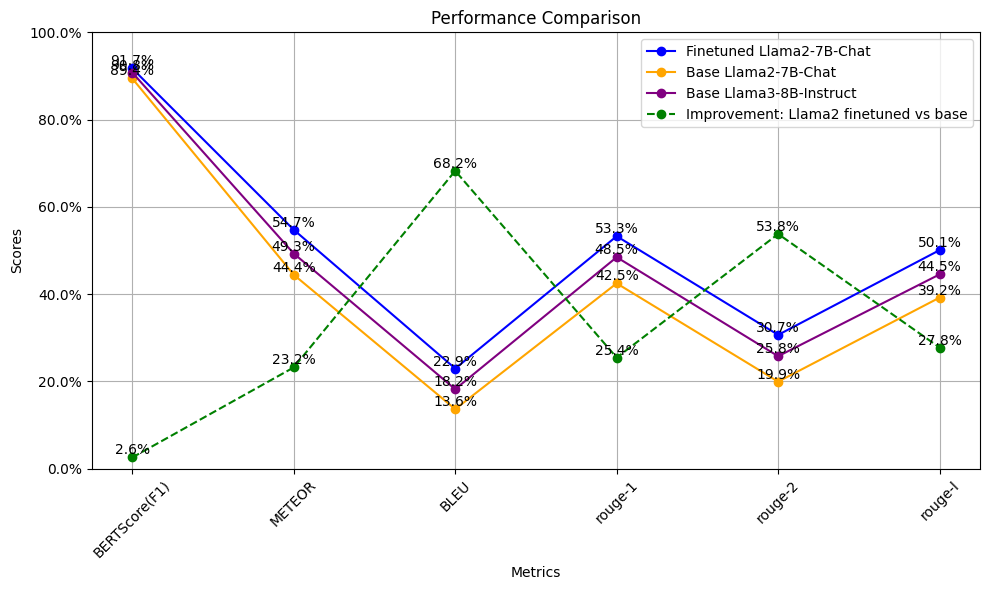

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to format y-axis labels as percentages
def percent(x, pos):
    return '%1.1f%%' % (x * 100)

# Define the x-axis labels
labels = ["BERTScore(F1)", "METEOR", "BLEU", "rouge-1", "rouge-2", "rouge-l"]

# Extract scores for finetuned llama2-7b-chat model
finetuned_llama2_scores = np.array([0.9171436856389046, 0.5474461102655611, 0.22939051090323534, 0.5326981310578925, 0.3065083438932236, 0.5008402663761499])

# Extract scores for base llama2-7b-chat model
base_llama2_scores = np.array([0.8943092213273048, 0.4443633704095649, 0.13634204780069573, 0.4246577955218664, 0.19931899333659336, 0.39204521176654894])

# Extract scores for base llama3-8b-instruct model
base_llama3_scores = np.array([0.9078916269540787, 0.4930108157554961, 0.1820904754376296, 0.4846081690050024,  0.25759552198048974, 0.44522714796918544])


# Calculate improvement as percentage
improvement_llama2 = ((finetuned_llama2_scores - base_llama2_scores) / base_llama2_scores)

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(labels, finetuned_llama2_scores, marker='o', color='blue',label='Finetuned Llama2-7B-Chat')
plt.plot(labels, base_llama2_scores, marker='o', color='orange',label='Base Llama2-7B-Chat')
plt.plot(labels, base_llama3_scores, marker='o', color='purple',label='Base Llama3-8B-Instruct')
plt.plot(labels, improvement_llama2, marker='o', color='green', linestyle='--', label='Improvement: Llama2 finetuned vs base')
plt.title('Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Set y-axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(percent))

# Set y-axis limit to represent 100%
plt.ylim(0, 1)

# Add labels for each point on Finetuned llama2 Model line
for i in range(len(labels)):
    plt.text(labels[i], finetuned_llama2_scores[i], f'{finetuned_llama2_scores[i]*100:.1f}%', ha='center', va='bottom')

# Add labels for each point on Base llama2 Model line
for i in range(len(labels)):
    plt.text(labels[i], base_llama2_scores[i], f'{base_llama2_scores[i]*100:.1f}%', ha='center', va='bottom')

# Add labels for each point on Base llama3 Model line
for i in range(len(labels)):
    plt.text(labels[i], base_llama3_scores[i], f'{base_llama3_scores[i]*100:.1f}%', ha='center', va='bottom')


# Add labels for each point on Improvement line
for i in range(len(labels)):
    plt.text(labels[i], improvement_llama2[i], f'{improvement_llama2[i]*100:.1f}%', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()



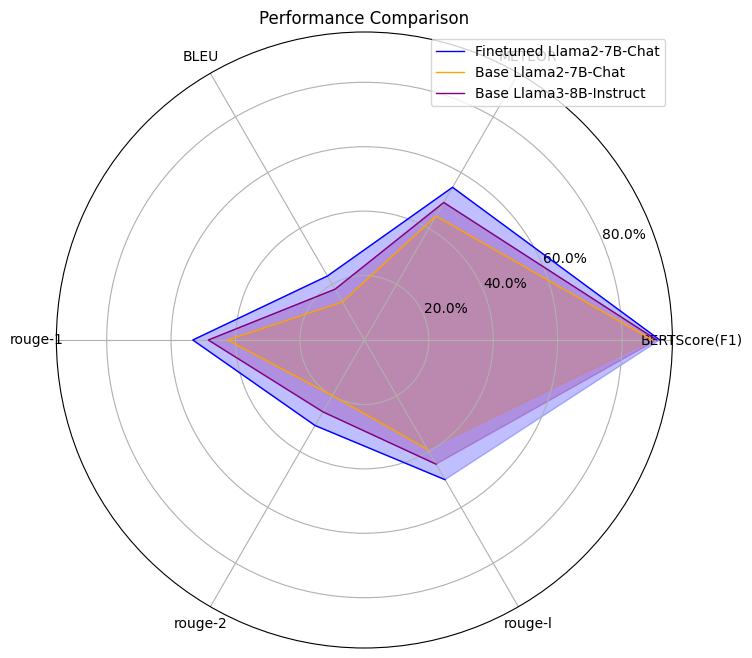

In [12]:
# Alternatively, visualize in a radar chart

import matplotlib.pyplot as plt
import numpy as np

# Define the function to format y-axis labels as percentages
def percent(x, pos):
    return '%1.1f%%' % (x * 100)

# Define the x-axis labels
labels = ["BERTScore(F1)", "METEOR", "BLEU", "rouge-1", "rouge-2", "rouge-l"]

# Extract scores for finetuned llama2-7b-chat model
finetuned_llama2_scores = np.array([0.9171436856389046, 0.5474461102655611, 0.22939051090323534, 0.5326981310578925, 0.3065083438932236, 0.5008402663761499])

# Extract scores for base llama2-7b-chat model
base_llama2_scores = np.array([0.8943092213273048, 0.4443633704095649, 0.13634204780069573, 0.4246577955218664, 0.19931899333659336, 0.39204521176654894])

# Extract scores for base llama3-8b-instruct model
base_llama3_scores = np.array([0.9078916269540787, 0.4930108157554961, 0.1820904754376296, 0.4846081690050024,  0.25759552198048974, 0.44522714796918544])

# Calculate the maximum possible score for each metric
max_scores = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Set up the radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the radar chart for each model
ax.plot(angles, finetuned_llama2_scores, color='blue', linewidth=1, label='Finetuned Llama2-7B-Chat')
ax.fill(angles, finetuned_llama2_scores, color='blue', alpha=0.25)
ax.plot(angles, base_llama2_scores, color='orange', linewidth=1, label='Base Llama2-7B-Chat')
ax.fill(angles, base_llama2_scores, color='orange', alpha=0.25)
ax.plot(angles, base_llama3_scores, color='purple', linewidth=1, label='Base Llama3-8B-Instruct')
ax.fill(angles, base_llama3_scores, color='purple', alpha=0.25)

# Set the title and add a legend
plt.title('Performance Comparison')
plt.legend(loc='upper right')

# Set y-axis tick labels as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(percent))

# Set the radial axis labels
plt.xticks(angles, labels)

# Add a grid
plt.grid(True)

# Display the radar chart
plt.show()


Overall, the finetuned Llama2-7B-Chat shows the strongest performance across all evaluation metrics compared to the base Llama2-7b-chat and base Llama3-8b-instruct models. The fine-tuned model achieves statistically significant improvements on the basis of its base model, which are particularly notable for METEOR, ROUGE-2, and ROUGE-L scores. The BERTScore was already good for its base model but has improved further with finetuning. While the BLEU score is still in the mediocre range, it has also seen an improvement from finetuning. When comparing base Llama2-7B-Chat with base Llama3-8B-Instruct, we can see the latter performs better than the former across all evaluation metrics as it have been trained with much larger high-quality data.

These results suggest that the finetuning process has been effective in enhancing the quality and similarity of the generated text to the reference texts based on these automatic evaluation metrics. And the efficacy of a fine-tuned model hinges significantly on the availability of domain-specific data that exhibits both high quality and relevance to the downstream tasks at hand.
